In [34]:
include("../../juliasrc/calculate_potentials.jl");

 Activating environment at `/run/media/zhanibek/BE7C43F57C43A74D/PROJECTS/local-bpm-e34/Project.toml`


In [2]:
Threads.nthreads()

14

In [6]:
using CSV, DataFrames, Glob

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278


In [148]:
indices = [17, 3, 13]

target_filenames = ["2020.05.29 data/testsamples/$(i).csv" for i in indices]
test_samples = [convert(Matrix,CSV.read(filename, header=false)) for filename in target_filenames];

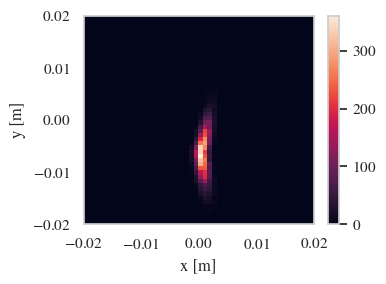

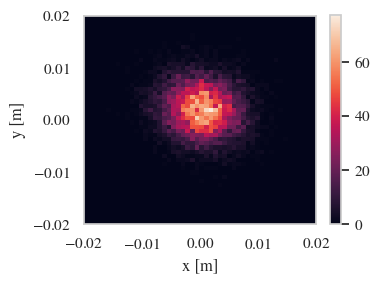

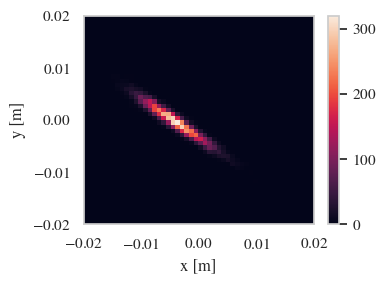

3-element Array{Nothing,1}:
 nothing
 nothing
 nothing

In [149]:
[plot(i) for i in test_samples]

In [150]:
test_sample_targets = []

for test in test_samples
    target = MinimizationTarget(test)
    push!(test_sample_targets, target)
end

In [151]:
# 1e3 works ok
function loss(a::MinimizationTarget, b::MinimizationTarget, w)
    currents =  mean(@. (a.currents - b.currents)^2)
    return (exp(w*(a.std_x - b.std_x)^2) - 1 + exp(w*(a.std_y - b.std_y)^2) - 1) + currents
end


loss (generic function with 1 method)

In [152]:
w_levels = 10.0 .^(range(2, stop=8, step=1))

7-element Array{Float64,1}:
    100.0
   1000.0
  10000.0
 100000.0
      1.0e6
      1.0e7
      1.0e8

In [153]:
function genetic_mutation_fit(minimization_target::MinimizationTarget, error_function=mse)
    parallel_instances = 16*10
    abs_tolerance = 100e-6

    initial_guesses = [get_random_distorted_gaussian_beam() for i in 1:parallel_instances]
    total_candidate_solutions = CandidateSolution[]

    @showprogress for i in 1:3
        # println("Iteration: $(i)")

        candidate_solutions = Vector{CandidateSolution}(undef, parallel_instances);
        Threads.@threads for i in 1:parallel_instances
            # print("$(Threads.threadid())")
            candidate_solutions[i] = greedy_fit(minimization_target, initial_guesses[i], error_function)
        end

        sort!(candidate_solutions)
        [push!(total_candidate_solutions, candidate_solutions[i]) for i in 1:3]
        top_beams = [candidate_solution.beam for candidate_solution in candidate_solutions[1:10]]

        initial_guesses = vcat([mutate_beam(beam) for beam in top_beams]...)
    end

    sort!(total_candidate_solutions)
    return total_candidate_solutions
end


genetic_mutation_fit (generic function with 4 methods)

In [154]:
fitting_results = []

for (i, w) in enumerate(w_levels)
    println(i)
    println()
    
    local_loss=((a, b) -> loss(a, b, w))
    one_sample = []
    for j in 1:length(test_sample_targets)
        # push!(one_sample, dummy_fit(test_sample_targets_with_noise[i][`j])[1])

        push!(
            one_sample,
            genetic_mutation_fit(test_sample_targets[j], local_loss))
    end
    push!(fitting_results, one_sample)
    
    
end

1



Progress: 100%|█████████████████████████████████████████| Time: 0:04:48
Progress: 100%|█████████████████████████████████████████| Time: 0:01:56
Progress: 100%|█████████████████████████████████████████| Time: 0:03:02


2



Progress: 100%|█████████████████████████████████████████| Time: 0:05:31
Progress: 100%|█████████████████████████████████████████| Time: 0:01:45
Progress: 100%|█████████████████████████████████████████| Time: 0:02:39


3



Progress: 100%|█████████████████████████████████████████| Time: 0:05:16
Progress: 100%|█████████████████████████████████████████| Time: 0:02:14
Progress: 100%|█████████████████████████████████████████| Time: 0:02:58


4



Progress: 100%|█████████████████████████████████████████| Time: 0:05:44
Progress: 100%|█████████████████████████████████████████| Time: 0:02:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:48


5



Progress: 100%|█████████████████████████████████████████| Time: 0:05:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:57
Progress: 100%|█████████████████████████████████████████| Time: 0:03:05


6



Progress: 100%|█████████████████████████████████████████| Time: 0:05:15
Progress: 100%|█████████████████████████████████████████| Time: 0:03:09
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47


7



Progress: 100%|█████████████████████████████████████████| Time: 0:03:49
Progress: 100%|█████████████████████████████████████████| Time: 0:03:07
Progress: 100%|█████████████████████████████████████████| Time: 0:02:42


In [155]:
fitting_results[1][1][1].error

2.7938997895827354e-6

In [156]:
for i in eachindex(fitting_results)
    plot(fitting_results[i][1].beam)
end

LoadError: type Array has no field beam

In [157]:
using Images
using ImageQualityIndexes

In [158]:
function get_ssim_error(x,y)
    a = fit(Histogram, (x[:,1], x[:,2]), (range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1), range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)))
    b = fit(Histogram, (y[:,1], y[:,2]), (range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1), range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)))
    # return mean((a.weights  - b.weights ).^2)
    assess_ssim(a.weights./maximum(a.weights), b.weights./maximum(b.weights))
end

get_ssim_error (generic function with 1 method)

In [174]:
ssim_scores = []
ssim_errors = []

for i in eachindex(fitting_results)
    ssim_scores_per_beam = []
    ssim_errors_per_beam = []
    
    for j in eachindex(fitting_results[i])  # Beam samples
        
        scores = [get_ssim_error(fitting_results[i][j][k].beam, test_samples[j]) for k in eachindex(fitting_results[i][j][1:5])]
        push!(ssim_scores_per_beam, mean(scores))
        push!(ssim_errors_per_beam, std(scores))
    end
    push!(ssim_scores, ssim_scores_per_beam)
    push!(ssim_errors, ssim_errors_per_beam)

end
   

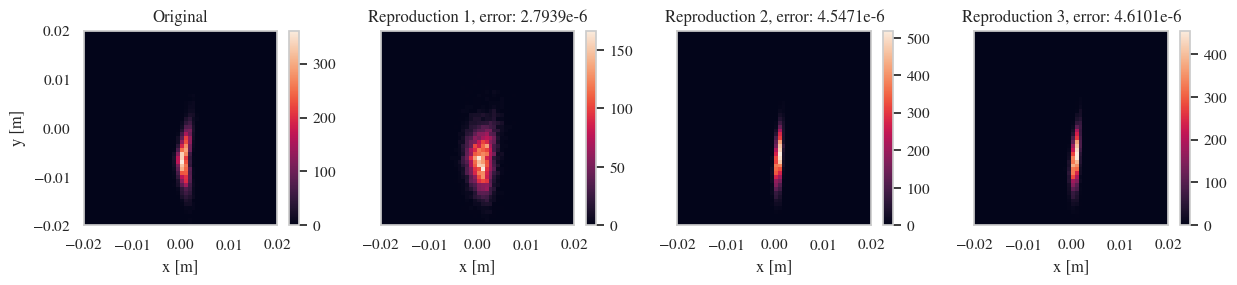

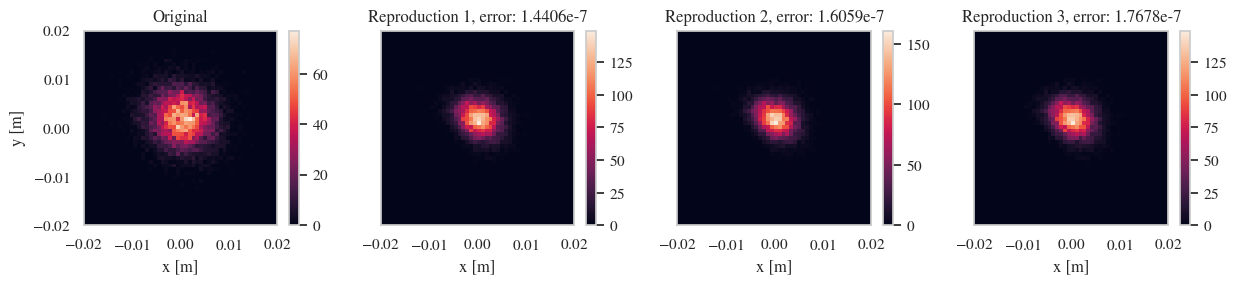

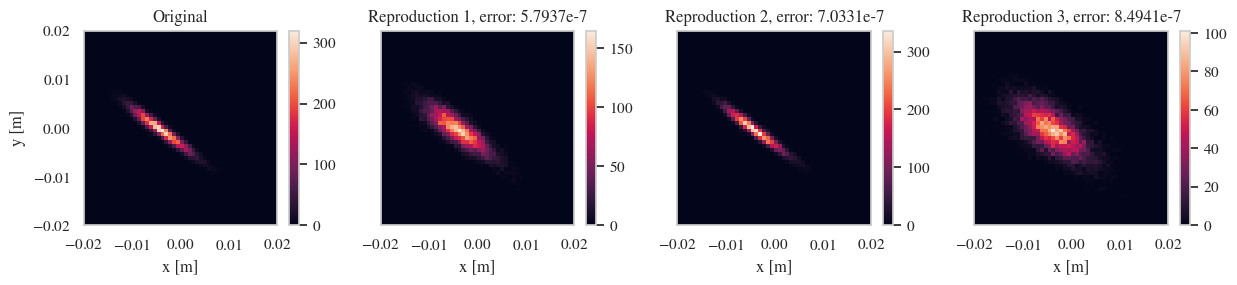

In [177]:
for i in eachindex(test_samples)
    compare_plot(test_samples[i], fitting_results[1][i][1:3])
end

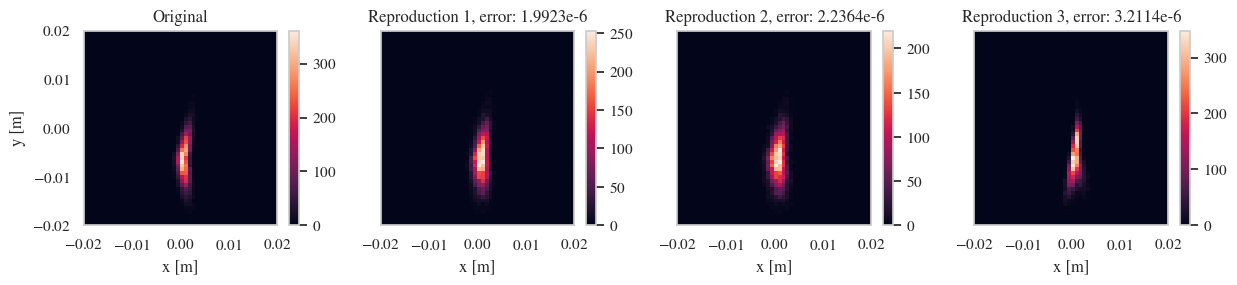

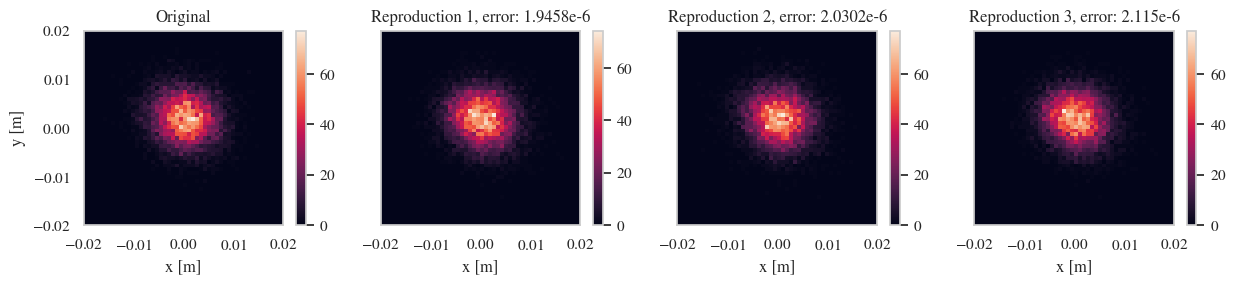

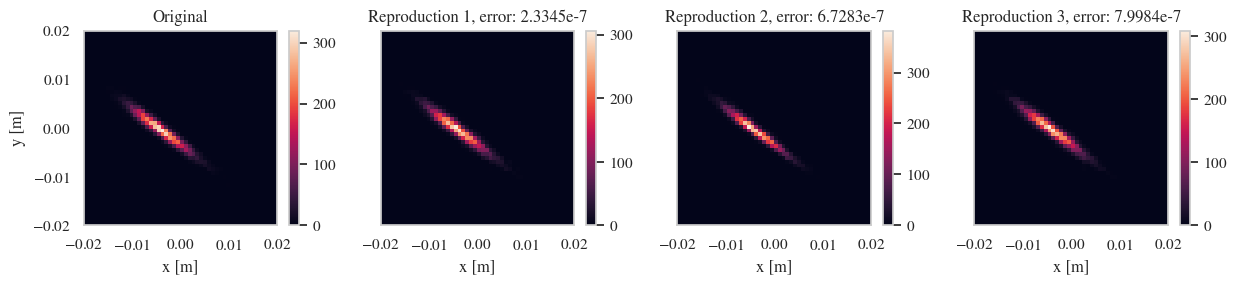

In [178]:
for i in eachindex(test_samples)
    compare_plot(test_samples[i], fitting_results[5][i][1:3])
end

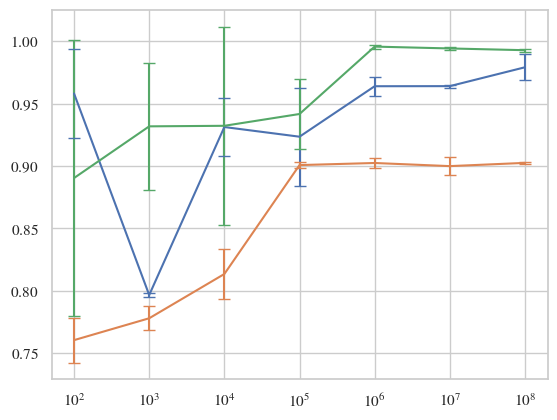

In [175]:
errorbar(
    w_levels, [ssim_scores[i][1] for i in eachindex(ssim_scores)],
    yerr=[ssim_errors[i][1] for i in eachindex(ssim_errors)]
)

errorbar(
    w_levels, [ssim_scores[i][2] for i in eachindex(ssim_scores)],
    yerr=[ssim_errors[i][2] for i in eachindex(ssim_errors)]
)

errorbar(
    w_levels, [ssim_scores[i][3] for i in eachindex(ssim_scores)],
    yerr=[ssim_errors[i][3] for i in eachindex(ssim_errors)]
)

xscale("log")
#plot(w_levels, ssim_scores[2])
#plot(w_levels, ssim_scores[3])